## Importing Libraries

In [ ]:
!nvidia-smi

Wed Jun  2 16:49:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#For Downloading the dataset on colab

#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/val-v0.4.tar.gz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz


In [ ]:
#!unzip val-v0.4.tar.gz

In [ ]:
#Extract dataset from the tar files
#!for f in *.tar.gz; do tar xf "$f"; done

In [ ]:
%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-bbldmots
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-bbldmots
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263866 sha256=a1c4f21cb33e6720cd08c478dc528dfda9743158d724d594560c993840b25335
  Stored in directory: /tmp/pip-ephem-wheel-cache-i9y2yxys/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools


In [ ]:
import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, LeakyReLU, ZeroPadding2D, Add
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import random

import cv2

import skimage.io as io

from pycocotools import mask as cocomask

import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [ ]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/content/drive/MyDrive/Food_recognition"


coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=1.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


## Exploring the data

In [ ]:
def plot_image(image_id, coco, mode='train'):
    #read the image
    img = coco.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/' + mode + '/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

In [ ]:
#Plotting a few random images

#np.random.seed(100)
#img_num = []
#rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
#for i in rand:
    #img_num.append(coco_train.getImgIds()[i])
#for ids in img_num:
    #plot_image(ids, coco_train)

## Loading and cleaning the data

Sorting the category ids by popularity

In [ ]:
def get_ordered_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

In [ ]:
# display COCO categories
categories = coco_train.loadCats(get_ordered_ids())
classes=[cat['name'] for cat in categories]
number_of_classes = len(classes)
print('COCO categories: ', number_of_classes)
print(classes)

COCO categories:  273
['veggie-burger', 'falafel-balls', 'bread-pita', 'rusk-wholemeal', 'frying-sausage', 'applesauce-unsweetened-canned', 'hazelnut', 'tea-peppermint', 'sauce-mushroom', 'sauce-soya', 'greek-yaourt-yahourt-yogourt-ou-yoghourt', 'green-bean-steamed-without-addition-of-salt', 'alfa-sprouts', 'beans-kidney', 'dates', 'focaccia', 'chocolate-cookies', 'tea-verveine', 'beef-sirloin-steak', 'beef-cut-into-stripes-only-meat', 'fruit-coulis', 'pizza-with-ham-baked', 'vegetable-mix-peas-and-carrots', 'cream', 'rice-whole-grain', 'artichoke', 'sesame-seeds', 'juice-apple', 'greek-salad', 'plums', 'dried-raisins', 'kefir-drink', 'veal-sausage', 'meat-terrine-pata-c', 'ice-tea', 'ham-croissant', 'soup-of-lentils-dahl-dhal', 'beetroot-raw', 'brioche', 'butter-spread-puree-almond', 'crunch-ma1-4esli', 'brownie', 'corn-crisps', 'mixed-seeds', 'bread-rye', 'bacon-cooking', 'pumpkin', 'flakes-oat', 'bread-5-grain', 'bread-fruit', 'rosti', 'pasta-noodles', 'hazelnut-chocolate-spread-nut

## Defining functions to manage the dataset

Function to filter the dataset

In [ ]:
def filterDataset(folder, mode, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Functions to create the masks

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

Data generators

In [ ]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    n_classes = len(classes) + 1
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        #mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, classes, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    n_classes = len(classes) + 1
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                final_mask = np.zeros((input_image_size[0], input_image_size[1]))
                for i in range(1, n_classes):
                    color = i + 1
                    new_mask = mask[j][:,:,i]*color
                    final_mask = np.maximum(new_mask, final_mask)
                ax.imshow(final_mask);
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

## Filtering the dataset and defining the generators

In [ ]:
classes = ['pasta-spaghetti','tomato-sauce', 'apple', 'bread-white', 'water']
#classes = ['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'carrot', 'rice', 'egg', 'mixed-vegetables', 'wine-red', 'apple', 'jam', 'potatoes-steamed', 'banana', 'cheese']
images_train, dataset_size_train, coco_train = filterDataset(folder_loc,'train',classes)

loading annotations into memory...
Done (t=1.72s)
creating index...
index created!


In [ ]:
images_val, dataset_size_val, coco_val = filterDataset(folder_loc,'val',classes)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
print("The training set size is:", dataset_size_train)
print("The validation set size is:", dataset_size_val)

The training set size is: 4091
The validation set size is: 220


In [ ]:
batch_size = 16
input_image_size = (256,256)
mask_type = 'binary'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

val_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc,
                            input_image_size, batch_size, 'val', mask_type)

## Testing if get_binary_mask function works

Class 0 mask: 


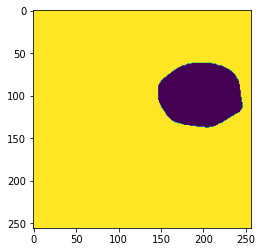

Class 1 mask: 


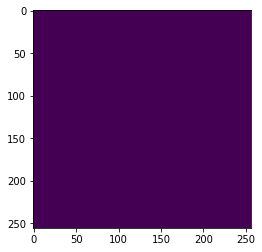

Class 2 mask: 


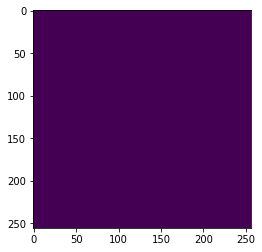

Class 3 mask: 


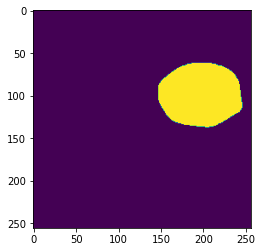

Class 4 mask: 


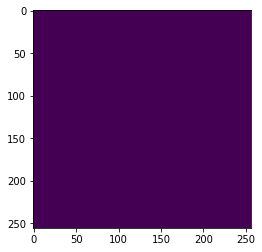

Class 5 mask: 


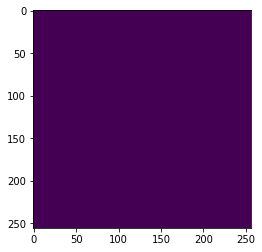

In [ ]:
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(images_train[5], classes, coco_train, catIds, input_image_size)

n_classes = len(classes) + 1
final_mask = np.zeros((input_image_size[0], input_image_size[1]))
for i in range(n_classes):
    color = i + 1
    new_mask = mask[:,:,i]*color
    plt.imshow(new_mask)
    print("Class {} mask: ".format(i))
    plt.show()
    #final_mask = np.maximum(new_mask, final_mask)

#plt.imshow(final_mask)

In [ ]:
#img_folder = '{}/{}/images'.format(folder_loc, 'train')
#train_img = getImage(images_train[5], img_folder, input_image_size)
#plt.imshow(train_img)

## Visualize the masks


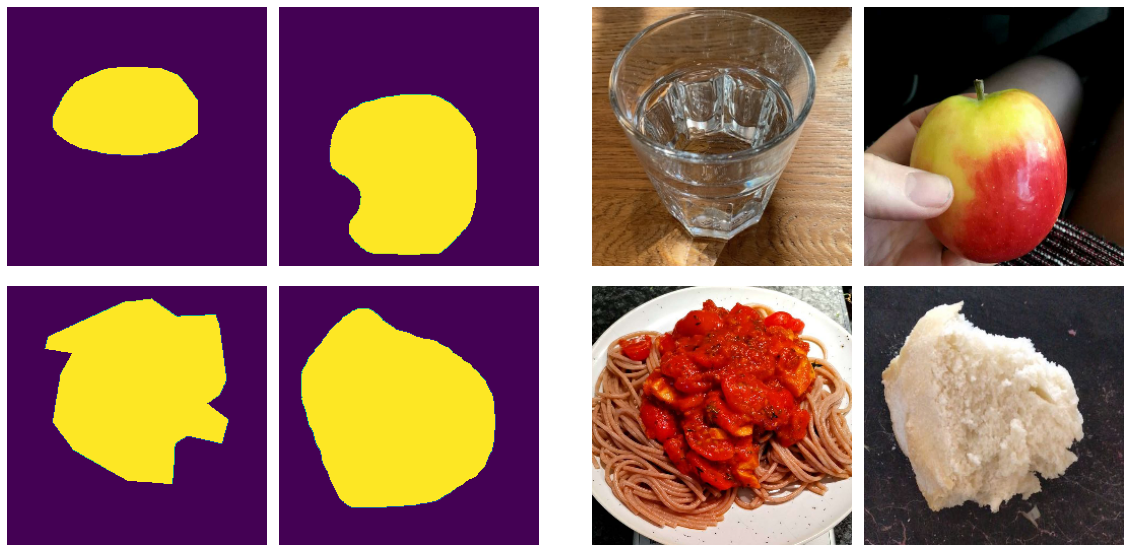

In [ ]:
visualizeGenerator(train_gen)

In [ ]:
img, mask = next(train_gen)
print("The shape of the image batch is: ", img.shape)
print("The shape of the mask batch is: ", img.shape)

The shape of the image batch is:  (16, 256, 256, 3)
The shape of the mask batch is:  (16, 256, 256, 3)


## Data augmentation

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for img, mask in gen:

        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)

        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 256, 256, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


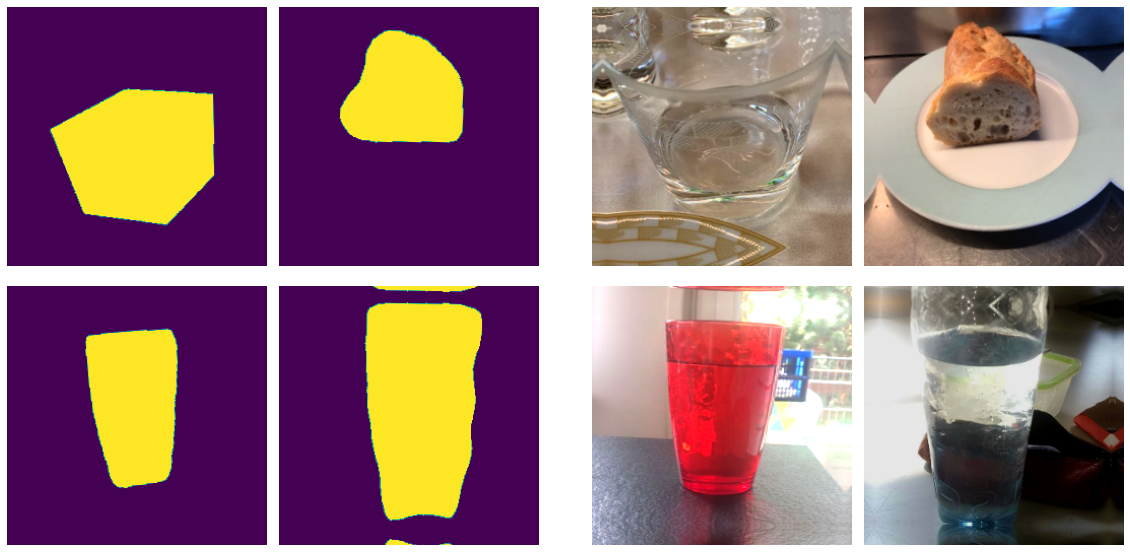

In [ ]:
visualizeGenerator(train_gen_aug)

## Building model architecture

Defining Blocks for Res_net model

In [ ]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    axis = 3
    default_bn_params = {
        'axis': axis,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [ ]:
def residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre'):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        cut: one of 'pre', 'post'. used to decide where skip connection is taken
    # Returns
        Output tensor for the block.
    """
    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
          shortcut = input_tensor
        elif cut == 'post':
          shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
      
        # continue with convolution layers
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2',**conv_params)(x)

        # add residual connection
        x = Add()([x, shortcut])

        return x

    return layer

Defining Res_Net model

In [ ]:
def res_net(input_shape):

  init_filters = 64

  input = Input(input_shape)

  no_scale_bn_params = get_bn_params(scale=False)
  bn_params = get_bn_params()
  conv_params = get_conv_params()

  x = BatchNormalization(name='bn_data', **no_scale_bn_params)(input)
  x = ZeroPadding2D((3,3))(x)
  x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
  x = BatchNormalization(name='bn0',**bn_params)(x)
  x = Activation('relu',name='relu0')(x)
  x = ZeroPadding2D((1,1))(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)

  repetitions = (3, 4, 6, 3)

  for stage, rep in enumerate(repetitions):
        for block in range(rep):

            filters = init_filters * (2 ** stage)

            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='post')(x)

            elif block == 0:
                x = residual_conv_block(filters, stage, block, strides=(2, 2), cut='post')(x)

            else:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre')(x)
            
  x = BatchNormalization(name='bn1', **bn_params)(x)
  x = Activation('relu', name='relu1')(x)

  model = Model(inputs=input, outputs=x, name='Res_Net')

  weights_path = folder_loc + '/resnet34_imagenet_1000_no_top.h5'
  model.load_weights(weights_path)

  return model

Defining Blocks for Res_U_net model

In [ ]:
def DecoderUpsamplingBlock(input_tensor, skip, filters, stage):
    up_name = 'decoder_stage{}_upsampling'.format(stage)
    conv1_name = 'decoder_stage{}a'.format(stage)
    conv2_name = 'decoder_stage{}b'.format(stage)
    concat_name = 'decoder_stage{}_concat'.format(stage)

    concat_axis = 3

    x = UpSampling2D(size=2, name=up_name)(input_tensor)

    if skip is not None:
        x = Concatenate(axis=concat_axis, name=concat_name)([x, skip])

    x = Conv_Bn_block(x, filters, block_name = conv1_name)
    x = Conv_Bn_block(x, filters, block_name = conv2_name)

    return x

def Conv_Bn_block(input_tensor, filters, block_name):
    conv_name = block_name + '_conv'
    act_name = block_name + '_relu'
    bn_name = block_name + '_bn'
    bn_axis = 3

    x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_uniform')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    x = Activation('relu', name=act_name)(x)

    return x

Defining Res_U_net model

In [ ]:
def Res_Unet(input_shape, classes, activation='softmax'):

    skip_connection_layers = ['stage4_unit1_relu1', 'stage3_unit1_relu1', 'stage2_unit1_relu1', 'relu0']
    decoder_filters=(256, 128, 64, 32, 16)
    n_upsample_blocks=5

    """ ResNet Model """
    backbone = res_net(input_shape)

    input = backbone.input
    
    x = backbone.output

    # extract skip connections
    skips = ([backbone.get_layer(i).output for i in skip_connection_layers])

    # building decoder blocks
    for i in range(n_upsample_blocks):

        if i < len(skips):
            skip = skips[i]
        else:
            skip = None

        x = DecoderUpsamplingBlock(x, skip, decoder_filters[i], stage=i)

    # model head (define number of output classes)
    x = Conv2D(filters=classes, kernel_size=(3, 3), padding='same', use_bias=True, kernel_initializer='glorot_uniform', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    # create keras model instance
    model = Model(inputs=input, outputs=x, name='Res_U_Net')

    return model

In [ ]:
number_of_classes=len(classes) + 1

model = Res_Unet((input_image_size[0], input_image_size[1], 3), number_of_classes)

model.summary()

Model: "Res_U_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________

## Defining custom losses and metrics

Defining the loss function

In [ ]:
from tensorflow.keras.activations import softmax
from typing import Callable, Union

def multiclass_weighted_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice loss.
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted Dice loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted Dice loss (tf.Tensor, shape=(None,))
        """
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true + y_pred) * class_weights # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss



## Training the model 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Defining class weights

In [ ]:
#Piece of code used to calculate the weights 

#pix_per_class = [0] * number_of_classes
#for i in range(len(images_train)):
#  mask = getNormalMask(images_train[i], classes, coco_train, catIds, input_image_size)
#  for x in mask:
#    for y in x:
#      pix_per_class[int(y)] += 1 
#print(pix_per_class)

#class_weights = [0] * number_of_classes
#pix_per_class = [514525249, 28946595, 23053801, 25746525, 8346787, 5901218, 13838666, 8172995, 8927856, 7052578, 8328663, 5211670, 8591286, 5763095, 4573908, 4789941, 3342511]
#total_pixels = 0
#for i in pix_per_class:
#  total_pixels = total_pixels + i

#for i in range(len(class_weights)):
#  weight = round(total_pixels / (number_of_classes * pix_per_class[i]), 3)
#  class_weights[i] = weight
#print(class_weights)


In [ ]:
#class_weights = [0.078, 1.392, 1.748, 1.565, 4.828, 6.829, 2.912, 4.931, 4.514, 5.714, 4.839, 7.733, 4.691, 6.993, 8.811, 8.414, 12.057]
class_weights = [0.229, 6.917, 10.457, 5.095, 1.762, 1.585]

Defining the Intersection over union metric

In [ ]:
%pip install -U --pre segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5) ]

Training the model

In [ ]:
n_epochs = 10

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size

lossFn = multiclass_weighted_dice_loss(class_weights=class_weights)


# Compile model
model.compile(loss = lossFn, optimizer = Adam(learning_rate = 1e-4), metrics=['accuracy', metrics])


#filepath = folder_loc + '/models/model_epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

#Define the callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    #ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]

# Start the training process
history = model.fit(x = train_gen_aug,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,  
                callbacks = callbacks,
                verbose = True)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (16, 256, 256, 6) (6 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
255/255 [==============================] - 244s 919ms/step - loss: 0.4719 - accuracy: 0.7972 - iou_score: 0.4468 - f1-score: 0.5450 - val_loss: 0.7396 - val_accuracy: 0.7162 - val_iou_score: 0.3047 - val_f1-score: 0.3285
Epoch 2/10
255/255 [==============================] - 231s 907ms/step - loss: 0.3349 - accuracy: 0.8748 - iou_score: 0.5387 - f1-score: 0.6312 - val_loss: 0.6052 - val_accuracy: 0.7322 - val_iou_score: 0.2913 - val_f1-score: 0.3427
Epoch 3/10
255/255 [==============================] - 231s 909ms/step - loss: 0.3024 - accuracy: 0.8884 - iou_score: 0.5886 - f1-score: 0.6761 - val_loss: 0.3734 - val_accuracy: 0.8393 - val_iou_score: 0.4974 - val_f1-score: 0.5984
Epoch 4/10
255/255 [==============================] - 230s 903ms/step - loss: 0.2884 - accuracy: 0.8935 - iou_score: 0.5978 - f1-score: 0.6837 - val_loss: 0.2601 - val_accuracy: 0.8927 - val_iou_score: 0.6794 - val_f1-score: 0.7625
Epoch 5/10
255/255 [==============================] - 228s 896ms/step - 

## Plot loss and accuracy graphs

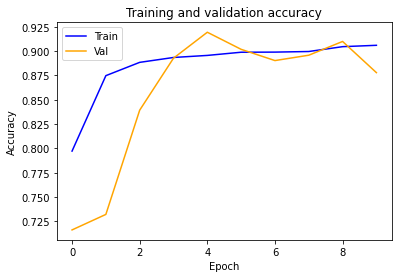

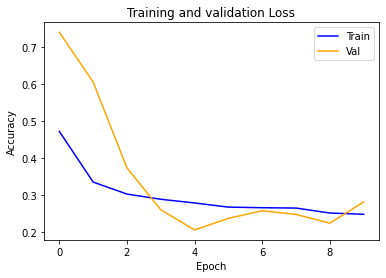

In [ ]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(history)

## Display model predictions

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
display_classes = ['background'] + classes

#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  for i in range(number_of_classes):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))
    print("Class {} mask: ".format(display_classes[i]))
    plt.show()

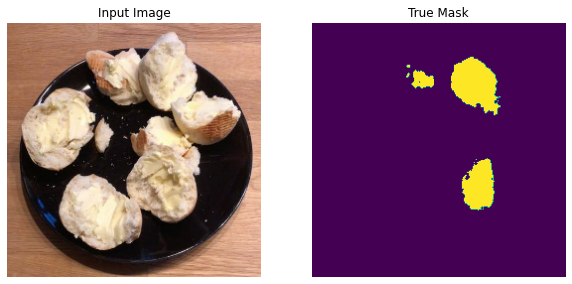

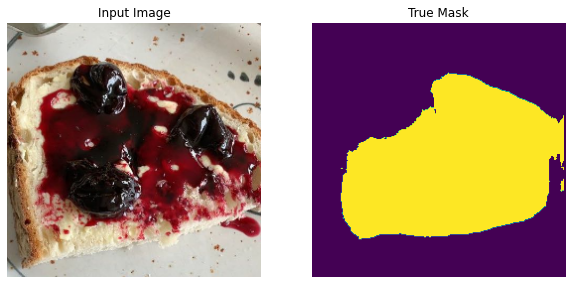

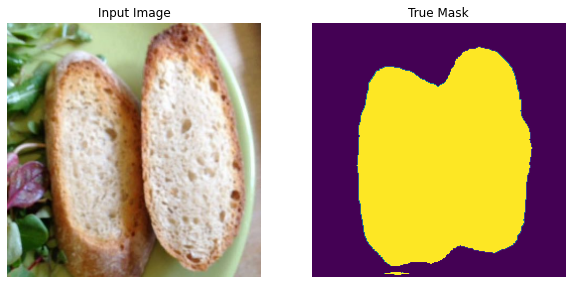

In [ ]:
#Plotting a few random images of the validations set

#np.random.seed(100)

val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(images_val), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

j = 0
for i in rand:
  #plot_image(val_images_ids[i], coco_val, 'val')
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)

  X[j] = image
  X[j] = X[j]/255.0

  j+=1

for i in range(len(X)):
#for i in range(1):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  display([X[i], create_mask(pred_mask)])
  #plot_predicted_masks(pred_mask)
